# Capstone - Diabetes Prediction - Exploratory Data Analysis


## Setup

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ranksums
from scipy.stats import chisquare

In [2]:
# Set path for our data that's gone through our datawrangling process
dw_file = '../data/df_dw.csv'

# Read raw data into a dataframe
df_dw = pd.read_csv(dw_file)

# Set path for saving our plots
plot_path = '../reports/figures'

In [3]:
df_dw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 733 entries, 0 to 732
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               733 non-null    int64  
 1   Glucose                   728 non-null    float64
 2   BloodPressure             731 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       731 non-null    float64
 6   DiabetesPedigreeFunction  733 non-null    float64
 7   Age                       733 non-null    int64  
 8   Outcome                   733 non-null    int64  
 9   BMI Category              731 non-null    object 
dtypes: float64(6), int64(3), object(1)
memory usage: 57.4+ KB


## Explore Correlations between Numerical Variables
Let's take a first look at how our numeric attributes are correlated.

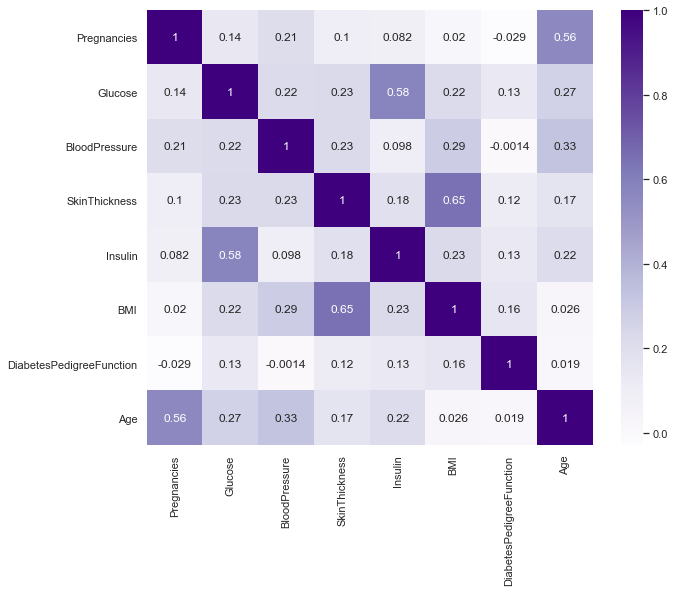

In [6]:
sns.set()
plt.subplots(figsize=(10,8))
#sns.heatmap(df_dw.loc[:,df_dw.columns != "Outcome" and df_dw.columns != 'BMI Category'].corr(), annot=True);
sns.heatmap(df_dw.loc[:, (df_dw.columns != 'BMI Category') & (df_dw.columns != 'Outcome')].corr(), \
            annot=True, cmap='Purples')
fig_path = os.path.join(plot_path, 'heatmap.png')
plt.savefig(fig_path, dpi=300);

We can see that age and pregnancies, insulin and glucose, and BMI and Skin Thickness show a correlation of approx .4-.7.  These make intuitive sense (the older a woman, the more years she's lived to have pregnancies, the higher the glucose, the more insulin, and the heavier someone is, the more skin they have on their tricep).  But we do not see a very high collinearity between our numeric features, which is good becuase logistic regresssion assumes we do not have attributes with high collinearity. 

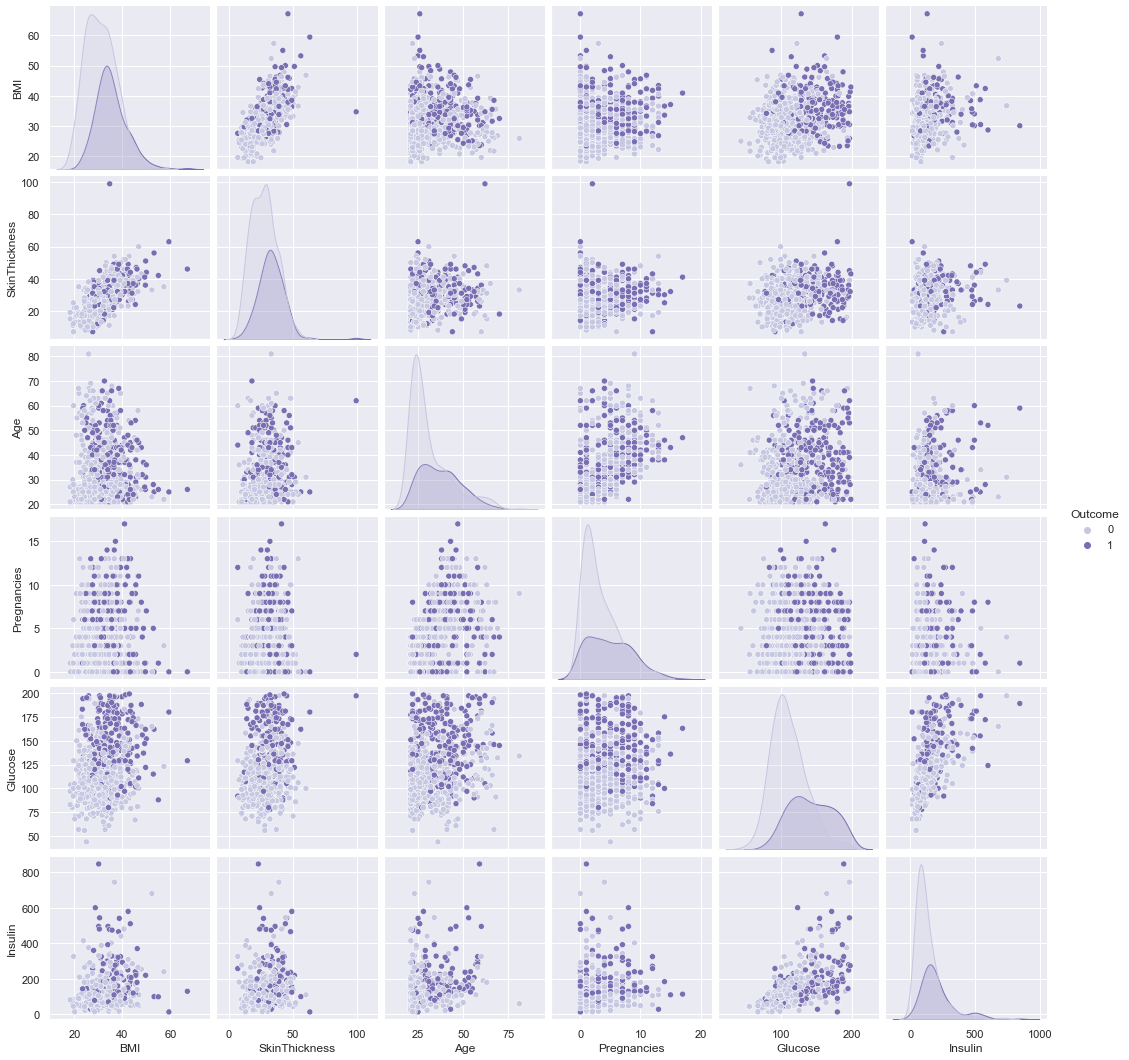

In [7]:
# Here is another way of looking at correlations.  
# Let's look at those features which look like they may be correlated, with a hue based on Outcome
_ = sns.pairplot(df_dw[['BMI','SkinThickness','Age','Pregnancies','Glucose','Insulin','Outcome']], hue='Outcome', palette='Purples')
fig_path = os.path.join(plot_path, 'pairplot.png')
plt.savefig(fig_path, dpi=300);

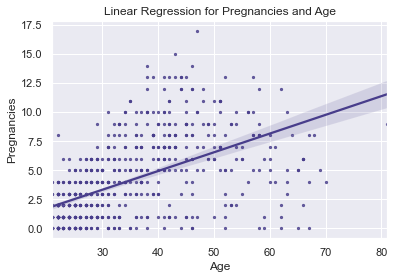

In [8]:
# Let's look at some of these features with higher correlations a bit more closely.
# Age and Pregnancies
_ = sns.regplot(x='Age',y='Pregnancies',data=df_dw, ci=95, color='darkslateblue', scatter_kws={"s": 5})
_ = plt.title('Linear Regression for Pregnancies and Age')

So we can see that there is some correlation between age and number of pregnancies, but the data is still all over the place, so presumably each attribute would contribute valuable information to our model.  In the next section we will see if either shows any correlation with outcome, and then we'll go from there.

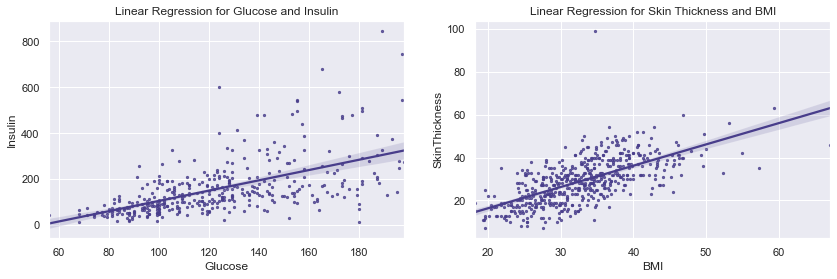

In [9]:
# Glucose vs. Insulin and BMI vs. SkinThickness
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))
_ = plt.subplot(1,2,1)
_ = sns.regplot(x='Glucose',y='Insulin',data=df_dw, ci=95, color='darkslateblue', scatter_kws={"s": 5})
_ = plt.title('Linear Regression for Glucose and Insulin')
_ = plt.subplot(1,2,2)
_ = sns.regplot(x='BMI',y='SkinThickness',data=df_dw, ci=95, color='darkslateblue', scatter_kws={"s": 5})
_ = plt.title('Linear Regression for Skin Thickness and BMI')
fig_path = os.path.join(plot_path, 'corr_features.png')
plt.savefig(fig_path, dpi=300);

So these two regressions are interesting.  Note that SkinThickness and Insulin are our two attributes which have many missing values, and each of these are somewhat highly correlated with another attribute.  For this reason, we may initially not include them in our model.  Let's see whether either of them show an association with Outcome.  

## Explore Relationships between Attributes and Outcome
### (Continous vs Categorical)

### Columns with Many Missing Values (SkinThickness and Insulin)

So now let's look at the two columns where we have lots of missing values and see how they relate to the outcome.

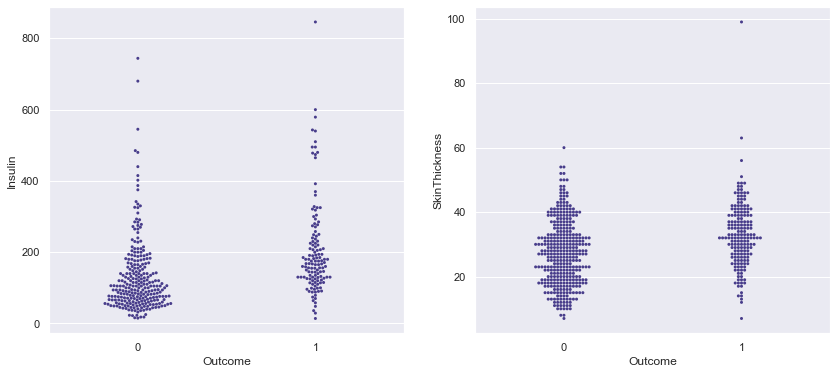

In [8]:
# Let's create a swarmplot of these vs Outcome
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
_ = plt.subplot(1,2,1)
_ = sns.swarmplot(x='Outcome', y='Insulin',data=df_dw, size=3, color='darkslateblue')
_ = plt.subplot(1,2,2)
_ = sns.swarmplot(x='Outcome', y='SkinThickness',data=df_dw, size=3, color='darkslateblue')

We can't tell much from these swarmplots, although the means do look like they may be slightly different for each population.  For each of these, we'd like to test a null hypothesis that outcome is not correlated with the attribute. Note a few things:
- neither attribute is normally distributed, which indicates we should use a non-parametric test
- both attributes have some pretty extreme outliers, which indicates we should construct a hypothesis test with a median instead of a mean

For that reason, let's use the [Rank Sums test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html).  For large samples such as ours, this test is considered a test of medians, with a null hypothesis that the median between the two populations are the same, and an alternative hypothesis that the values for the first population are more likely to be higher than those for the second.  

In [9]:
# First separate attribute into two different populations, with an Outcome of 0 or 1.
Insulin_0 = df_dw[df_dw['Outcome']==0]['Insulin']
Insulin_1 = df_dw[df_dw['Outcome']==1]['Insulin']
# Now let's run the Rank Sums Test
# Note that for this test, it matters in which order we put the two populations into the function call.  
# Our alternative hypothesis is that Insulin values with outcomes of 1 are more likely to be larger than 
# those with an outcome of 0. 
# If we switch the order of the arguments to the function, we get a higher p-value.  
test_stat, p_value = ranksums(Insulin_1, Insulin_0)
print("Results for Insulin")
print("Observed Difference in Medians: ",Insulin_0.median() - Insulin_1.median())
print("P-value: ", p_value)

# And we'll do the same for SkinThickness.
SkinThickness_0 = df_dw[df_dw['Outcome']==0]['SkinThickness']
SkinThickness_1 = df_dw[df_dw['Outcome']==1]['SkinThickness']
test_stat, p_value = ranksums(SkinThickness_1, SkinThickness_0)
print("\nResults for SkinThickness")
print("Observed Difference in Medians: ",SkinThickness_0.median() - SkinThickness_1.median())
print("P-value: ", p_value)


Results for Insulin
Observed Difference in Medians:  -67.0
P-value:  0.000301520660459829

Results for SkinThickness
Observed Difference in Medians:  -5.0
P-value:  2.743634715118732e-06


So we see that our p-values are very small, indicating that we can reject our null hypothesis that the two populations have the same median, which in turn indicates that these attributes may provide useful information in predicting outcome.  

Let's, out of curiosity, also run a permutation test with the median as a measure and see if we get a similar result.  We're going to run this test for other attributes as well, so let's define a function.  

In [10]:
def permutation_test(df, colname, func, size=10_000):
    """ Takes our dataframe and runs a permutation test on the 
    column for populations with Outcome=0 and Outcome=1.  Returns
    an numpy array containing one calculated value (based on func)
    for each permutation. """
    
    # We'll create an empty array 
    diff_array = np.empty(size)

    # Let's create another df that does not have any null values
    df_for_perm = df[[colname,'Outcome']].dropna().copy()
                    
    # Now make a for loop that does the following num_per times:
    # 1. makes a permutation of the column
    # 2. calculates the difference in the functional value for outcome 0 and 1 for that permutation. 
    for i in range(size):
        permutation = np.random.permutation(df_for_perm[colname])
        diff_array[i] = func(permutation[df_for_perm['Outcome']==0]) - \
            func(permutation[df_for_perm['Outcome']==1])
    
    return diff_array

Observed difference in medians for Insulin:  -67.0


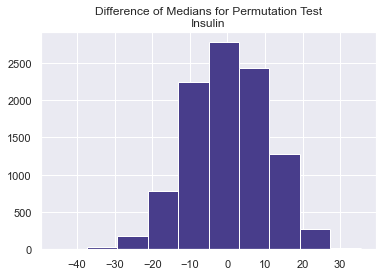

In [11]:
# Calculated observed difference of medians
diff_medians = Insulin_0.median() - Insulin_1.median()
print('Observed difference in medians for Insulin: ', diff_medians)
# Run the permutation test
diff_per_medians = permutation_test(df_dw, "Insulin", np.median, 10_000)

_ = plt.hist(diff_per_medians, color='darkslateblue')
_ = plt.title('Difference of Medians for Permutation Test\nInsulin')

Observed difference in medians for SkinThickness:  -5.0


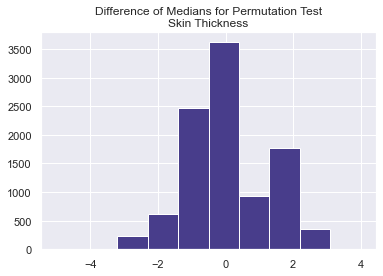

In [12]:
# Let's do the same for SkinThickness
diff_medians = SkinThickness_0.median() - SkinThickness_1.median()
print('Observed difference in medians for SkinThickness: ', diff_medians)
# Run the permutation test
diff_per_medians = permutation_test(df_dw, "SkinThickness", np.median, 10_000)

_ = plt.hist(diff_per_medians, color='darkslateblue')
_ = plt.title('Difference of Medians for Permutation Test\nSkin Thickness')

We can visually see from the histograms that we did not generate a single permutation where the difference in medians was as extreme as our observed value for either attribute.  This would suggest that we can assume that the difference in medians is significant.  However, since as mentioned before, each of these attributes shows a significant correlation with another attribute, *I will choose to not include these columns in my models initially.*

### Glucose vs. Outcome

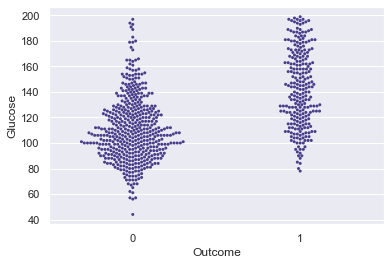

In [13]:
# Let's first see how Glucose and Outome are related
_ = sns.swarmplot(x='Outcome', y='Glucose',data=df_dw, size=3, color='darkslateblue')

It appears that glucose may be a good predictor of outcome. We can see from the histogram generated in our pairplot above that the two distributions both have significant right skew, and the distribution for an Outcome of 1 does not look at all normally distributed.  For this reason we will use the same permutation test we used above.  

Observed difference in means for Glucose:  -31.593656903765705


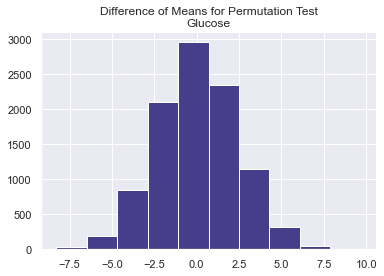

In [14]:
# Let's separate into two populations
Glucose_0 = df_dw[df_dw['Outcome']==0]['Glucose']
Glucose_1 = df_dw[df_dw['Outcome']==1]['Glucose']

# Since we don't have significant outliers let's use np.mean this time
diff_means = np.mean(Glucose_0.dropna()) - np.mean(Glucose_1.dropna())
print('Observed difference in means for Glucose: ', diff_means)
# Run the permutation test
diff_per_means = permutation_test(df_dw, "Glucose", np.mean, 10_000)

_ = plt.hist(diff_per_means, color='darkslateblue')
_ = plt.title('Difference of Means for Permutation Test\nGlucose')

So we can see that in 10,000 permutations we did not generate a single one where the difference in means 
was as large as our observed difference in means, which means the p-value is very very small. Therefore we can say that the null hypothesis is false, or that the difference between the mean glucose value between the two populations is statistically significant.

### BMI vs Outcome

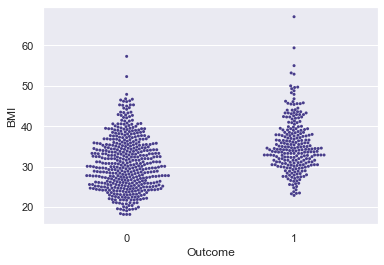

In [15]:
# See how some of our attributes vary with outcome
_ = sns.swarmplot(x='Outcome', y='BMI',data=df_dw, size=3, color='darkslateblue')

It's not as clear that BMI will be a good predictor of outcome. We can see from the histogram generated in our pairplot above that the two distributions both have significant right skew, and both distributions have a long right tail.  For this reason we will use the same permutation test we used above, but we'll use a median test this time since we have some real outliers.  

Observed difference in medians for BMI:  -3.8999999999999986


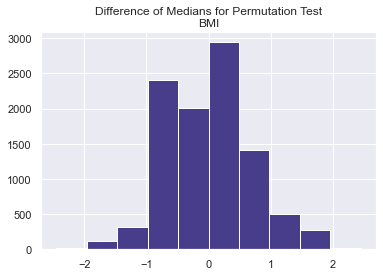

In [16]:
# Let's separate into two populations
BMI_0 = df_dw[df_dw['Outcome']==0]['BMI']
BMI_1 = df_dw[df_dw['Outcome']==1]['BMI']

# Since we have significant outliers let's use np.median this time
diff_medians = np.median(BMI_0.dropna()) - np.median(BMI_1.dropna())
print('Observed difference in medians for BMI: ', diff_medians)
# Run the permutation test
diff_per_medians = permutation_test(df_dw, "BMI", np.median, 10_000)

_ = plt.hist(diff_per_medians, color='darkslateblue')
_ = plt.title('Difference of Medians for Permutation Test\nBMI')

Again, we can see that we generate no permutations with a difference as large as the observed, so the p-value is very very small.  Let's for kicks run this again using the median instead.  

Observed difference in means for BMI:  -4.4162292474401035


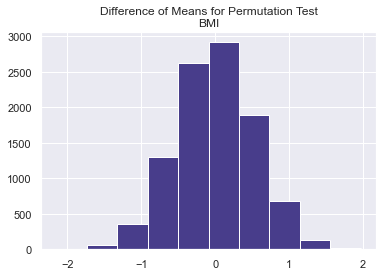

In [17]:
# Let's use np.mean this time
diff_means = np.mean(BMI_0.dropna()) - np.mean(BMI_1.dropna())
print('Observed difference in means for BMI: ', diff_means)
# Run the permutation test
diff_per_means = permutation_test(df_dw, "BMI", np.mean, 10_000)

_ = plt.hist(diff_per_means, color='darkslateblue')
_ = plt.title('Difference of Means for Permutation Test\nBMI')

Our conclusion is the same: BMI is a strong predictor of outcome.

### Diabetes Pedigree Function vs Outcome

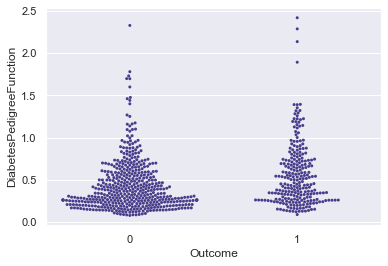

In [18]:
# See how Diabetes Pedigree Function varies with Outcome
_ = sns.swarmplot(x='Outcome', y='DiabetesPedigreeFunction',data=df_dw, size=3, color='darkslateblue')

Observed difference in medians for DiabetesPedigreeFunction:  -0.11349999999999999


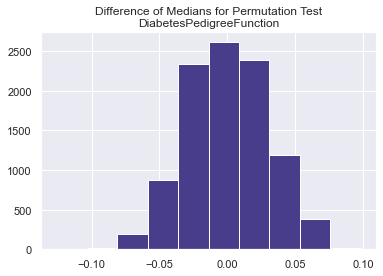

In [19]:
# Let's separate into two populations
DPF_0 = df_dw[df_dw['Outcome']==0]['DiabetesPedigreeFunction']
DPF_1 = df_dw[df_dw['Outcome']==1]['DiabetesPedigreeFunction']

# We have some outliers, so et's use the median test
diff_medians = np.median(DPF_0.dropna()) - np.median(DPF_1.dropna())
print('Observed difference in medians for DiabetesPedigreeFunction: ', diff_medians)
# Run the permutation test
diff_per_medians = permutation_test(df_dw, "DiabetesPedigreeFunction", np.median, 10_000)

_ = plt.hist(diff_per_medians, color='darkslateblue')
_ = plt.title('Difference of Medians for Permutation Test\nDiabetesPedigreeFunction')

Once again, we did not generate a single permutation with a value as extreme as our observed value, so we can conclude this will be a contributing factor for predicting outcome.

### Blood Pressure vs Outcome

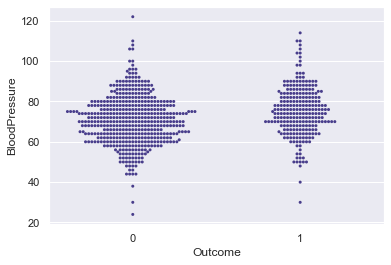

In [20]:
# See how Blood Pressure varies with Outcome
_ = sns.swarmplot(x='Outcome', y='BloodPressure',data=df_dw, size=3, color='darkslateblue')

Observed difference in medians for BloodPressure:  -4.0


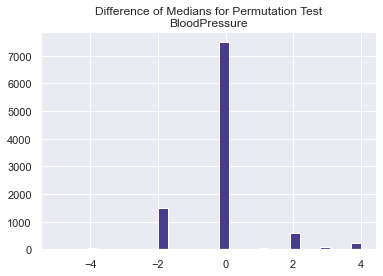

In [21]:
# Let's separate into two populations
BP_0 = df_dw[df_dw['Outcome']==0]['BloodPressure']
BP_1 = df_dw[df_dw['Outcome']==1]['BloodPressure']

# We have some outliers, so et's use the median test
diff_medians = np.median(BP_0.dropna()) - np.median(BP_1.dropna())
print('Observed difference in medians for BloodPressure: ', diff_medians)
# Run the permutation test
diff_per_medians = permutation_test(df_dw, "BloodPressure", np.median, 10_000)

_ = plt.hist(diff_per_medians, color='darkslateblue', bins=30)
_ = plt.title('Difference of Medians for Permutation Test\nBloodPressure')

This looks odd.  The data looks quantized.  Let's investigate blood pressure data again by looking at the unique values.  

In [22]:
df_dw['BloodPressure'].value_counts().sort_index().head(10)

24.0     1
30.0     2
38.0     1
40.0     1
44.0     4
46.0     2
48.0     5
50.0    13
52.0    11
54.0    11
Name: BloodPressure, dtype: int64

Ah, we can see that probably due to the nature of the equipment, values for blood pressure are indeed quantized, so when we take the difference in medians these values will also be quantized.  It does look like we may have generated a few permutations with a significant difference in means, so let's calculate the p-value.

In [23]:
p_value = sum(abs(diff_per_medians) >= abs(diff_medians)) / len(diff_per_medians)
print(p_value)

0.0269


Interesting, so we have a small but meaningful value for the p-value. Let's run this again with means to try and smooth out the quantization. In this particular case using the median led to misleading results.

Observed difference in means for BloodPressure:  -4.384877158034527


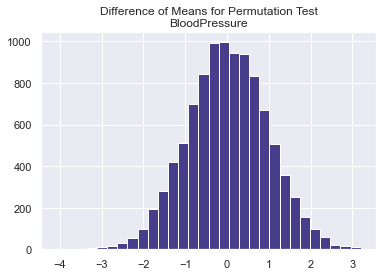

In [24]:
# mean test
diff_means = np.mean(BP_0.dropna()) - np.mean(BP_1.dropna())
print('Observed difference in means for BloodPressure: ', diff_means)
# Run the permutation test
diff_per_means = permutation_test(df_dw, "BloodPressure", np.mean, 10_000)

_ = plt.hist(diff_per_means, color='darkslateblue', bins=30)
_ = plt.title('Difference of Means for Permutation Test\nBloodPressure')

And now we can see that indeed out observed value is extreme, and so we can say that there is indeed a difference between the two populations.

### Age vs Outcome

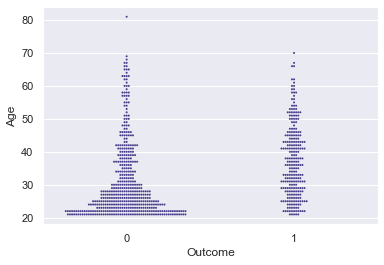

In [25]:
# See how Age varies with Outcome
_ = sns.swarmplot(x='Outcome', y='Age',data=df_dw, size=2, color='darkslateblue')

It appears that younger people are certainly less likely to be diagnosed with diabetes.

Observed difference in medians for Age:  -9.0


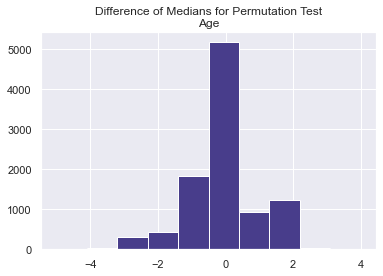

In [26]:
# Let's separate into two populations
Age_0 = df_dw[df_dw['Outcome']==0]['Age']
Age_1 = df_dw[df_dw['Outcome']==1]['Age']

# We have some outliers, so et's use the median test
diff_medians = np.median(Age_0.dropna()) - np.median(Age_1.dropna())
print('Observed difference in medians for Age: ', diff_medians)
# Run the permutation test
diff_per_medians = permutation_test(df_dw, "Age", np.median, 10_000)

_ = plt.hist(diff_per_medians, color='darkslateblue')
_ = plt.title('Difference of Medians for Permutation Test\nAge')

Once again, we did not generate a single permutation with a value as extreme as our observed value, so we can conclude this will be a contributing factor for predicting outcome.

### Pregnancies vs Outcome

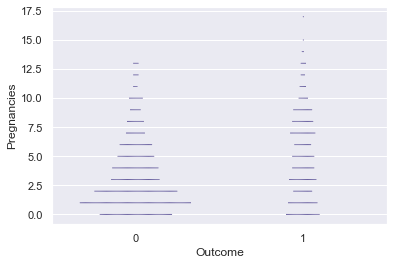

In [27]:
# See how Pregnancies varies with Outcome
_ = sns.swarmplot(x='Outcome', y='Pregnancies',data=df_dw, size=1, color='darkslateblue')

Observed difference in medians for Pregnancies:  -3.0


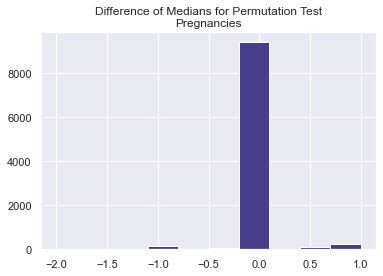

In [28]:
# Let's separate into two populations
Pregnancies_0 = df_dw[df_dw['Outcome']==0]['Pregnancies']
Pregnancies_1 = df_dw[df_dw['Outcome']==1]['Pregnancies']

# We have some outliers, so et's use the median test
diff_medians = np.median(Pregnancies_0.dropna()) - np.median(Pregnancies_1.dropna())
print('Observed difference in medians for Pregnancies: ', diff_medians)
# Run the permutation test
diff_per_medians = permutation_test(df_dw, "Pregnancies", np.median, 10_000)

_ = plt.hist(diff_per_medians, color='darkslateblue')
_ = plt.title('Difference of Medians for Permutation Test\nPregnancies')

Once again, we did not generate a single permutation with a value as extreme as our observed value, so we can conclude this will be a contributing factor for predicting outcome.  Once again we see that since the raw data is quantized, so is the data based on medians.  

## Explore Relationship between BMI Category and Outcome 
### (Categorical vs Categorical)

Let's consider how the BMI Categorical variable is associated with Outcome

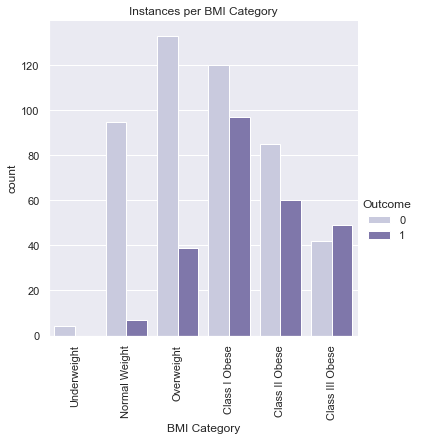

In [29]:
_ = sns.catplot(x="BMI Category", hue='Outcome', kind="count", palette="Purples", data=df_dw, \
                          order = ['Underweight','Normal Weight','Overweight','Class I Obese','Class II Obese','Class III Obese']\
)
_ = plt.xticks(rotation='vertical')
_ = plt.title('Instances per BMI Category')

So it appears that there is certainly a higher percentage of positive outcomes for people who are classified as Obese as compared with Underweight, Normal Weight, or Overweight.  It may make sense to recategorize our data into just four classes by combining the three Obese classes into one. 

We want to do a statistical test on these different populations, so we'll conduct a Chi-Square test.  

In [30]:
# First we need to calculate our table of observed frequencies
Observed = df_dw.groupby(by=['Outcome','BMI Category'])['BMI'].count().reset_index()
Observed = Observed.pivot(index='Outcome', columns='BMI Category', values='BMI')
Observed = Observed.reindex(columns=['Underweight','Normal Weight','Overweight','Class I Obese','Class II Obese','Class III Obese'])

In [31]:
# We have  NaN value which should be 0 so let's fill that
Observed = Observed.fillna(0)
Observed

BMI Category,Underweight,Normal Weight,Overweight,Class I Obese,Class II Obese,Class III Obese
Outcome,,,,,,
0,4.0,95.0,133.0,120.0,85.0,42.0
1,0.0,7.0,39.0,97.0,60.0,49.0


In [32]:
# Now we calculate our expected values which is (row total)*(column total) / (grand total)
Expected = np.empty(Observed.shape)
GrandTotal = Observed.sum(axis=1).sum()

for i in range(Observed.shape[0]):
    for j in range(Observed.shape[1]):
        #print(i,j,Observed.sum(axis=1)[i] * Observed.sum(axis=0)[j] / GrandTotal)
        Expected[i,j] = int(Observed.sum(axis=1)[i] * Observed.sum(axis=0)[j] / GrandTotal)

Expected = pd.DataFrame(Expected).reindex(Observed.index)
Expected.columns = Observed.columns

In [33]:
Expected

BMI Category,Underweight,Normal Weight,Overweight,Class I Obese,Class II Obese,Class III Obese
Outcome,,,,,,
0,2.0,66.0,112.0,142.0,95.0,59.0
1,1.0,35.0,59.0,74.0,49.0,31.0


In [34]:
# Now we can do our chi squared test for an Outcome of 0
chi_sq, p_value = chisquare(Observed.iloc[0,:], Expected.iloc[0,:], ddof=0)
print('Outcome of 0:\n',chi_sq, p_value)

# Now we can do our chi squared test for an Outcome of 1
chi_sq, p_value = chisquare(Observed.iloc[1,:], Expected.iloc[1,:], ddof=0)
print('Outcome of 1:\n',chi_sq, p_value)

Outcome of 0:
 28.03931161034273 3.576032937389121e-05
Outcome of 1:
 50.24931032392565 1.2321859416467027e-09


And voila, we can see that the p-values for both of these arrays are extremely small, and so we can confidently say that the difference between the observed and expected values for both outcomes are statistically significant.  In other words, BMI Category will be a good predictor of Outcome. 

## Conclusions

We have explored the relationships between the various attributes and between each attribute the the outcome.  We have seen that we do not have a high amount of collinearity between attributes, but there are some attributes that do show some correlation.  For this reason we will proceed with an initial Linear Regression model without including all the attributes.  We have to attributes for which we are missing a high percentage of values, and we concluded that we can, initially, not include these in our models for two reasons: a) they are each correlated with another attribute, and b) they do not strongly predict the outcome.  Each of our other attributes did show some statistically significant relationship with the Outcome, with glucose and BMI showing the strongest relationship, so we will start modeling with those two attributes.  We additionally showed through a Chi Square test that BMI Category is significantly associated with Outcome.  

On to training our models!  